In [1]:
# Import the necessary libraries. You can use pip to install these packages if you do not already have them

import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Create a connection to the database

path_name = "engagement.db"
conn = sqlite3.connect(path_name)

In [3]:
# Functions to help you explore the engagement data, see the examples below

sql = lambda query: pd.read_sql_query(query, conn)
sql_to_clipboard = lambda query: sql(query).to_clipboard(index=False)

In [227]:
# When you run this cell, you should see 10 rows of eligibility data in a pandas DataFrame

sql(
"""
    SELECT * FROM eligibility
    LIMIT 10;
"""
)

,eligibility_id,benefits_start_date,date_of_birth,sex,family_status,client
0,799710,2019-01-01,1969-09-11,M,1,Client A
1,606621,2019-01-01,1977-11-12,M,1,Client A
2,724689,2019-01-01,1974-10-17,M,0,Client A
3,138360,2019-01-01,1967-07-24,M,0,Client A
4,666621,2019-01-01,1973-12-10,M,0,Client A
5,871909,2019-01-01,1974-04-24,M,1,Client A
6,814046,2019-01-01,1977-03-16,M,1,Client A
7,723937,2019-01-01,1974-10-17,M,0,Client A
8,784477,2019-01-01,1969-08-23,M,1,Client A
9,623545,2019-01-01,1974-12-09,M,1,Client A


In [228]:
# When you run this cell, the results of the query are saved to your clipboard so that you can easily
# paste the data into Excel

# sql_to_clipboard(
# """
#     SELECT * FROM eligibility
#     LIMIT 10;
# """
# )

## EDA

In [4]:
# getting an understanding for how large each table is

tables = ['eligibility', 'client_metadata', 'accounts',
          'recommendations', 'claims']


for table in tables:
    print(f'{table}: ', sql(f'''
        SELECT COUNT(*)
        FROM {table}
        '''))


eligibility:     COUNT(*)
0      2820
client_metadata:     COUNT(*)
0         6
accounts:     COUNT(*)
0      1207
recommendations:     COUNT(*)
0     10680
claims:     COUNT(*)
0      1322


These tables are fairly small in size. I'll easily be able to hold all the data in memory.

In [5]:
# creating a separate pandas df for each table

eligibility = sql('''SELECT * FROM eligibility''')
client_metadata = sql('''SELECT * FROM client_metadata''')
accounts = sql('''SELECT * FROM accounts''')
recommendations = sql('''SELECT * FROM recommendations''')
claims = sql('''SELECT * FROM claims''')


# list of dataframes
dfs = [eligibility, client_metadata, accounts,
       recommendations, claims]


# understanding each table via pandas
for table, df in zip(tables, dfs):
    print(table), df.info()

eligibility
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   eligibility_id       2820 non-null   object
 1   benefits_start_date  2820 non-null   object
 2   date_of_birth        2820 non-null   object
 3   sex                  2820 non-null   object
 4   family_status        2820 non-null   int64 
 5   client               2820 non-null   object
dtypes: int64(1), object(5)
memory usage: 132.3+ KB
client_metadata
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   client         6 non-null      object
 1   income_range   6 non-null      object
 2   hr_engagement  6 non-null      object
dtypes: object(3)
memory usage: 272.0+ bytes
accounts
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120

just an initial observation is that none of the tables contain missing values, so imputation won't be necessary at any point

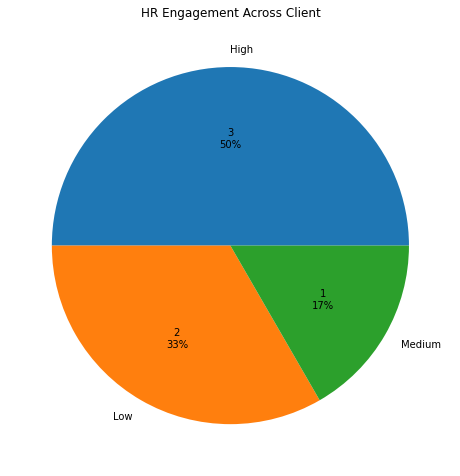

In [39]:
fig, ax = plt.subplots(figsize=(8,12), facecolor='w')

def label_function(val):
    return f'{val/100 * len(client_metadata):.0f}\n{val:.0f}%'

client_metadata.groupby('hr_engagement').size().plot(kind='pie',
                                        autopct=label_function, ax=ax)

ax.set_title('HR Engagement Across Client')
ax.set_ylabel('');

Creating a larger recommendations dataframe where recommendations, accounts, and eligibility dfs are all merged together

In [8]:
recommendations_df = recommendations\
    .merge(accounts, on='account_id')\
    .merge(eligibility, on='eligibility_id')

recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10680 entries, 0 to 10679
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   account_id           10680 non-null  object
 1   recommendation_id    10680 non-null  object
 2   date                 10680 non-null  object
 3   specialty            10680 non-null  object
 4   provider_id          10680 non-null  object
 5   eligibility_id       10680 non-null  object
 6   client_x             10680 non-null  object
 7   benefits_start_date  10680 non-null  object
 8   date_of_birth        10680 non-null  object
 9   sex                  10680 non-null  object
 10  family_status        10680 non-null  int64 
 11  client_y             10680 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.1+ MB


In [9]:
'''sanity check to make sure both client_x 
and client_y columns are the same then dropping client_x and
renaming client y'''

recommendations_df['client_x'].equals(recommendations_df['client_y'])

True

In [10]:
recommendations_df.drop('client_x', axis=1, inplace=True)
recommendations_df.rename(columns={'client_y':'client'}, inplace=True)


# merge with client_metadata
recommendations_df = recommendations_df.merge(client_metadata, on='client')

recommendations_df.head()

,account_id,recommendation_id,date,specialty,provider_id,eligibility_id,benefits_start_date,date_of_birth,sex,family_status,client,income_range,hr_engagement
0,403925840,6578968814,2021-02-28,Psychiatrist,98690718,724689,2019-01-01,1974-10-17,M,0,Client A,"$20,000 - $44,999",Low
1,403925840,5280596652,2021-02-28,Psychiatrist,96885602,724689,2019-01-01,1974-10-17,M,0,Client A,"$20,000 - $44,999",Low
2,403925840,9524543024,2021-02-28,Psychiatrist,57088025,724689,2019-01-01,1974-10-17,M,0,Client A,"$20,000 - $44,999",Low
3,403925840,7424617339,2021-02-28,Psychiatrist,55082760,724689,2019-01-01,1974-10-17,M,0,Client A,"$20,000 - $44,999",Low
4,403925840,7983655531,2021-02-28,Psychiatrist,01568508,724689,2019-01-01,1974-10-17,M,0,Client A,"$20,000 - $44,999",Low


Creating a larger claims dataframe where recommendations, accounts, and eligibility dfs are all merged together

In [11]:
claims_df = claims.merge(accounts, on='account_id')\
                  .merge(eligibility, on='eligibility_id')

# dropping one client column and renaming the other
claims_df.drop('client_x', axis=1, inplace=True)
claims_df.rename(columns={'client_y':'client'}, inplace=True)

# merging with client_metadata and grabbing specialty from recommendations
provider_id_and_specialty = recommendations[['specialty', 'provider_id']]
claims_df = claims_df.merge(client_metadata, on='client')\
                     .merge(provider_id_and_specialty, on='provider_id')

In [15]:
# claims_df.head()

In [13]:
# saving the separate dataframes to .csv files

df_names = ['recommendations_df', 'claims_df']
dfs = [recommendations_df, claims_df]

for df, df_name in zip(dfs, df_names):
    df.to_csv(f'{df_name}.csv', index=False)

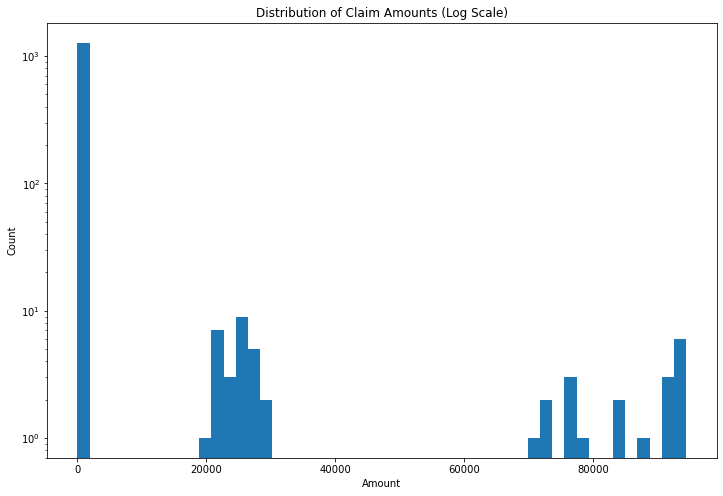

In [239]:
# histogram of claim amounts

fig, ax = plt.subplots(figsize=(12,8))
ax.hist(claims_df['amount'], bins=50, log=True)
ax.set_title('Distribution of Claim Amounts (Log Scale)')
ax.set_xlabel('Amount')
ax.set_ylabel('Count');

In [240]:
claims_df['amount'].value_counts()

210.0      27
206.0      25
187.0      25
191.0      22
221.0      22
           ..
78403.0     1
92561.0     1
270.0       1
1368.0      1
21693.0     1
Name: amount, Length: 199, dtype: int64

In [241]:
# very positively skewed - see mean vs. median diferences

claims_df['amount'].describe()

count     1322.000000
mean      1939.960666
std      10673.649892
min         15.000000
25%        191.000000
50%        211.000000
75%        254.000000
max      94374.000000
Name: amount, dtype: float64

In [242]:
recommendations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10680 entries, 0 to 10679
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   account_id           10680 non-null  object
 1   recommendation_id    10680 non-null  object
 2   date                 10680 non-null  object
 3   specialty            10680 non-null  object
 4   provider_id          10680 non-null  object
 5   eligibility_id       10680 non-null  object
 6   benefits_start_date  10680 non-null  object
 7   date_of_birth        10680 non-null  object
 8   sex                  10680 non-null  object
 9   family_status        10680 non-null  int64 
 10  client               10680 non-null  object
 11  income_range         10680 non-null  object
 12  hr_engagement        10680 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.1+ MB


In [52]:
# examining the differences between eligible employees and employees with accounts
eligible_employees = eligibility['eligibility_id'].nunique()
num_accounts = accounts['account_id'].nunique()

print(f"""There are {eligible_employees} eligible employees
and there are {num_accounts} actual users
meaning {round((num_accounts/eligible_employees)*100, 3)}% of eligible employees signed up""")

There are 2820 eligible employees
and there are 1207 actual users
meaning 42.801% of eligible employees signed up


In [243]:
unique_users = recommendations_df['account_id'].nunique()

print(f'There are {unique_users} individual accounts receiving recommendations')

There are 836 individual accounts receiving recommendations


In [244]:
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 1321
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   account_id           1322 non-null   object 
 1   provider_id          1322 non-null   object 
 2   date                 1322 non-null   object 
 3   amount               1322 non-null   float64
 4   status               1322 non-null   object 
 5   eligibility_id       1322 non-null   object 
 6   benefits_start_date  1322 non-null   object 
 7   date_of_birth        1322 non-null   object 
 8   sex                  1322 non-null   object 
 9   family_status        1322 non-null   int64  
 10  client               1322 non-null   object 
 11  income_range         1322 non-null   object 
 12  hr_engagement        1322 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 144.6+ KB


In [57]:
unique_claims_users = claims_df['account_id'].nunique()
unique_recommendation_users = recommendations_df['account_id'].nunique()

print(f'''There are {unique_claims_users} individual accounts submitting claims
and {unique_recommendation_users} receiving recommendations''')

There are 568 individual accounts submitting claims
and 836 receiving recommendations


In [246]:
'''
Seeing if all the account id values in claims are
present in the account id values in recommendations
'''

claims_ids = claims_df['account_id']
recs_ids = recommendations_df['account_id']

claims_ids_in_recs = claims_ids.isin(recs_ids)

# they are
# claims_ids_in_recs.all()

# now the reverse
# recs_ids_in_claims = recs_ids.isin(claims_ids)

# # They are not
# recs_ids_in_claims.all()


In [247]:
not_in_claims = recs_ids[~recs_ids\
                                   .isin(claims_ids)]

not_in_claims.nunique()

245

This checks out since there are 836 unique IDs receiving recommendations and only 568 unique IDs submitting claims... meaning:
- only ~70.69% of individuals receiving recommendations are submitting claims


Considering this initial look at the data, it seems the most important part of the engagement funnel to focus on is converting step 3, recomendations, to step 4, seeing a physician.
- This is assuming that all individual users who see a physician are also submitting claims via the platform.

In [25]:
eligibility['family_status'].value_counts()

0    1495
1    1325
Name: family_status, dtype: int64

In [64]:
# separate users dataframe with sex and family status information

eligibility_cols = eligibility[['eligibility_id', 'sex', 'family_status']]

accounts_with_sex_and_fam_stat = accounts.merge(eligibility_cols, on='eligibility_id')

accounts_with_sex_and_fam_stat.head()

,eligibility_id,account_id,client,sex,family_status
0,724689,403925840,Client A,M,0
1,871909,706133529,Client A,M,1
2,623545,832983386,Client A,M,1
3,646120,443728379,Client A,M,1
4,563295,802453624,Client A,M,1


In [65]:
female_users = accounts_with_sex_and_fam_stat[accounts_with_sex_and_fam_stat['sex'] == 'F']['account_id'].nunique()
male_users = accounts_with_sex_and_fam_stat[accounts_with_sex_and_fam_stat['sex']=='M']['account_id'].nunique()

print(f'Female users: {female_users}\nMale users: {male_users}')

Female users: 707
Male users: 500


In [66]:
family_plan_users = accounts_with_sex_and_fam_stat[accounts_with_sex_and_fam_stat['family_status']==1]['account_id'].nunique()
individual_plan_users = accounts_with_sex_and_fam_stat[accounts_with_sex_and_fam_stat['family_status']==0]['account_id'].nunique()


# family_plan_users = eligibility[eligibility['family_status']==1]['family_status'].count()
# individual_plan_users = eligibility[eligibility['family_status']==0]['family_status'].count()

print(f'Family Plan users: {family_plan_users}\nIndividual Plan users: {individual_plan_users}')

Family Plan users: 531
Individual Plan users: 676


In [32]:


eligibility['client'].value_counts

<bound method IndexOpsMixin.value_counts of 0       Client A
1       Client A
2       Client A
3       Client A
4       Client A
          ...   
2815    Client F
2816    Client F
2817    Client F
2818    Client F
2819    Client F
Name: client, Length: 2820, dtype: object>

In [54]:
# comparing users by client
client_count = dict()

for client in accounts['client'].unique():
    client_count[client] = accounts[accounts['client'] == client]['client'].count()

    
for k, v in client_count.items():
    print(f'{k}: {v}')

Client A: 45
Client B: 136
Client C: 471
Client D: 69
Client E: 210
Client F: 276
